In [18]:
import sys, os
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras.backend as K
import azure_chestxray_cam, azure_chestxray_utils, azure_chestxray_keras_utils

In [19]:
import keras_contrib
model = azure_chestxray_keras_utils.build_model(keras_contrib.applications.densenet.DenseNetImageNet121)

Weights for the model were loaded successfully


<class 'numpy.ndarray'>


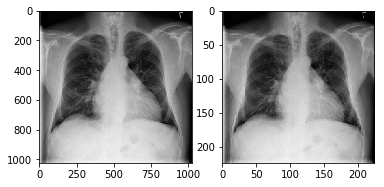

In [20]:
import cv2
cv2_image = cv2.imread('00000001_000.png')
plt.subplot(121)
plt.imshow(cv2_image)
print(type(cv2_image))
cv2_image = cv2.resize(cv2_image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.subplot(122)
plt.imshow(cv2_image)

In [22]:
from keras.models import Model

predictions = model.predict(cv2_image[None,:,:,:])
predictions
conv_map_model = Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
conv_features = conv_map_model.predict(cv2_image[None,:,:,:])
conv_features = conv_features[0, :, :, :] #np.squeeze(conv_features)
class_weights = model.layers[-1].get_weights()

In [ ]:
def normalize_nd_array(crt_array):
    # Normalised [0,1]
    crt_array = crt_array - np.min(crt_array)
    return(crt_array/np.ptp(crt_array))

In [23]:
def get_score_and_cam_picture(cv2_input_image, DenseNetImageNet121_model):
# based on https://github.com/jacobgil/keras-cam/blob/master/cam.py
    width, height, _ = cv2_input_image.shape
#     print(width, height)
    class_weights = DenseNetImageNet121_model.layers[-1].get_weights()[0]
    print('Class weigh', class_weights.shape)
    final_conv_layer = DenseNetImageNet121_model.layers[-3]
    print('Final conv', final_conv_layer.get_weights(), final_conv_layer.input_shape, final_conv_layer.output_shape)
    get_output = K.function([DenseNetImageNet121_model.layers[0].input], 
                            [final_conv_layer.output, \
                             DenseNetImageNet121_model.layers[-1].output])
    [conv_outputs, prediction] = get_output([cv2_input_image[None,:,:,:]])
    print('CONV OUT before', conv_outputs.shape, 'PREDICTI', prediction.shape)
    conv_outputs = conv_outputs[0, :, :, :]
    prediction = prediction[0,:]
    print('CONV OUT after', conv_outputs.shape, 'PREDICTI', prediction.shape)
    
    #Create the class activation map.
    predicted_disease = np.argmax(prediction)
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[:2])
    print('CAM', cam.shape)
    for i, w in enumerate(class_weights[:, predicted_disease]):
            cam += w * conv_outputs[:, :, i]
    
    return prediction, cam, predicted_disease

In [24]:
# azure_chestxray_utils.print_image_stats_by_channel(cv2_image)
cv2_image = normalize_nd_array(cv2_image)
cv2_image = 255*cv2_image
cv2_image=cv2_image.astype('uint8')
# azure_chestxray_utils.print_image_stats_by_channel(cv2_image)
print('Image', cv2_image.shape)
predictions, cam_image, predicted_disease_index = \
get_score_and_cam_picture(cv2_image, model)
predictions

Image (224, 224, 3)
Class weigh (1024, 14)
Final conv [] (None, 7, 7, 1024) (None, 7, 7, 1024)
CONV OUT before (1, 7, 7, 1024) PREDICTI (1, 14)
CONV OUT after (7, 7, 1024) PREDICTI (14,)
CAM (7, 7)


array([9.8963809e-01, 1.6660921e-03, 1.0000000e+00, 1.7012003e-11,
       2.0246129e-17, 0.0000000e+00, 0.0000000e+00, 9.9999988e-01,
       1.0000000e+00, 5.5852216e-21, 4.4074966e-15, 1.2068992e-04,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [25]:

# cam image (overimposed on orig Xray image)

blended_image = azure_chestxray_cam.process_cam_image(cam_image, cv2_image)
plot_cam_results(blended_image, cam_image, cv2_image, \
                 'abc')

NameError: name 'plot_cam_results' is not defined

In [17]:
layer = model.layers[-3]
# layer?

In [16]:
# model.summary()